In [2]:
from open3d import *
import numpy as np
import os
import sys
import random
import math
import glob
import matplotlib.pyplot as plt
import scipy.interpolate as si
from ipywidgets import FloatProgress
from IPython.display import display
import splipy as sp

In [3]:
def read_mesh(meshdir):
    if os.path.isfile(meshdir):
        print('Mesh File successfully loaded')
        mesh = read_triangle_mesh(meshdir)
        print('Vertices: '+str(len(np.asarray(mesh.vertices))))
        print('Triangles: '+str(len(np.asarray(mesh.triangles))))
        return mesh
    else:
        print('File Directory does not exist')

def read_pcd(filedir):
    if os.path.isfile(filedir):
        print('Point Cloud File successfully loaded')
        return read_point_cloud(filedir)
    else:
        print('File Directory does not exist')

def write_pcd(pcd, filedir):
    if not os.path.isfile(filedir):
        print('Point Cloud File successfully created')
        write_point_cloud(filedir, pcd)
    else:
        print('File Directory already exists')
        
def create_pcd(pts):
    pcd = PointCloud()
    pcd.points = Vector3dVector(pts)
    return pcd

def rotate_pcd(pcd, theta):
    points = np.asarray(pcd.points)
    r_x = np.array([[1,0,0],[0,math.cos(theta[0]),-math.sin(theta[0])],[0,math.sin(theta[0]),math.cos(theta[0])]])
    r_y = np.array([[math.cos(theta[1]),0,math.sin(theta[1])],[0,1,0],[-math.sin(theta[1]),0,math.cos(theta[1])]])
    r_z = np.array([[math.cos(theta[2]),-math.sin(theta[2]),0],[math.sin(theta[2]),math.cos(theta[2]),0],[0,0,1]])   
    r = np.dot(r_z, np.dot(r_y,r_x))
    points = np.matmul(points, r)
    pcd.points = Vector3dVector(points)
    return pcd

def pcd_processing(pcd, angle):
    angle = math.radians(angle)
    points = np.asarray(pcd.points)
    x = points[:,0]
    y = points[:,2] + abs(points[:,2].min())
    z = points[:,1]
    pcd = create_pcd(np.array([x, y, z]).transpose())
    return rotate_pcd(pcd, [0,angle,0])

In [4]:
def closest_distance(points, max_neighbors):
    distances = []
    tree = KDTreeFlann(create_pcd(points))
    search_radius = abs(points[:,0].max() - points[:,0].min())
    for point in points:
        neighbors = list(tree.search_hybrid_vector_3d(point, radius=search_radius, max_nn=max_neighbors+1)[2])[1:]
        for neighbor in neighbors:
            distances.append(np.sqrt(neighbor))
    return max(distances)

In [5]:
def intersection(p1, p2, y):
    x1, y1, z1 = p1
    x2, y2, z2 = p2
    new_x = ((y - y1)*(x2 - x1)/(y2 - y1)) + x1
    new_z = ((y - y1)*(z2 - z1)/(y2 - y1)) + z1
    return np.array([new_x, y, new_z])

def get_midpoints(mesh):
    triangles = np.asarray(mesh.triangles)
    vertices = np.asarray(mesh.vertices)[:,1]
    midpoints = np.zeros((len(triangles),2))
    distances = []
    for idx in range(len(triangles)):
        triangle = triangles[idx]
        current_vertices = sorted([vertices[triangle[0]], vertices[triangle[1]], vertices[triangle[2]]])
        midpoint = (current_vertices[2]+current_vertices[0])/2
        midpoints[idx] = np.array([idx,midpoint])
        distances.append(midpoint - current_vertices[0])
    max_distance = np.max(distances)
    return max_distance, midpoints

def mesh_slicing(mesh, density=4, num_sections=1):
    triangles = np.asarray(mesh.triangles)
    vertices = np.asarray(mesh.vertices)
    max_distance, midpoints = get_midpoints(mesh)
    
    tolerance = max_distance
    increment = tolerance/density
    min_y = midpoints[:,1].min()
    max_y = midpoints[:,1].max()
    current_y = min_y

    sections = []
    for i in range(num_sections):
        p1 = i*(100/num_sections)
        p2 = (i+1)*(100/num_sections)
        q1 = np.percentile(midpoints[:,1],p1)
        q2 = np.percentile(midpoints[:,1],p2)
        current_section = midpoints[midpoints[:,1] >= q1 - (tolerance+increment)]
        current_section = current_section[current_section[:,1] <= q2 + (tolerance+increment)]
        sections.append([q2,current_section])
    
    slices = []
    points = np.array([0,0,0])
    print('|Slicing Mesh|\n')
    print(f'Tolerance: {tolerance}')
    
    f = FloatProgress(min=min_y, max=max_y)
    display(f)
    
    for section in sections:
        current_max = section[0]
        current_midpoints = section[1]
        while current_y <= current_max:
            current_midpoints = current_midpoints[current_midpoints[:,1] >= current_y - tolerance]
            current_interval = current_midpoints[current_midpoints[:,1] <= current_y + tolerance]
            current_slice = np.array([0,0,0])
            for midpoint in current_interval:
                triangle = triangles[int(midpoint[0])]
                triangle_points = np.array([vertices[triangle[0]], vertices[triangle[1]], vertices[triangle[2]]])
                pts_above = triangle_points[triangle_points[:,1] > current_y]
                pts_below = triangle_points[triangle_points[:,1] < current_y]
                pts_intersect = triangle_points[triangle_points[:,1] == current_y]
                if len(pts_above) > 0 and len(pts_below) > 0:
                    for pt_below in pts_below:
                        for pt_above in pts_above:
                            current_slice = np.vstack((current_slice,intersection(pt_below,pt_above,current_y)))
                for pt_intersect in pts_intersect:
                    current_slice = np.vstack((current_slice,pt_intersect))
            if len(current_slice.shape) == 2:
                current_slice = np.unique(current_slice[1:],axis=0)
                slices.append(current_slice)
                points = np.vstack((points,current_slice))
            current_y += increment
            f.value = current_y
    f.value = max_y
    points = points[1:]
    print('|Finished Slicing Mesh|\n')
    print(f'Number of Slices: {len(slices)}')
    print(f'Number of Points: {len(points)}\n')
    return points, slices

In [6]:
filedir = '/Users/nickf/Desktop/Custom-Fit/Data/Subject Meshes/nf0_100.ply'
mesh = read_mesh(filedir)

Mesh File successfully loaded
Vertices: 75002
Triangles: 150000


|Slicing Mesh|

Tolerance: 8.803703703703718


FloatProgress(value=0.03548387096774193, max=1786.1055555555554, min=0.03548387096774193)

|Finished Slicing Mesh|

Number of Slices: 1624
Number of Points: 690580

|Refining Slices|

Finding Slice Cutoffs


FloatProgress(value=0.0, max=1623.0)

Cutting Slices


FloatProgress(value=665.0, max=1623.0, min=665.0)


|Finished Refining Slices|

Number of Slices: 959
Number of Points: 365142


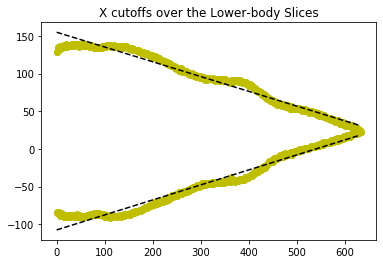

In [121]:
points, slices = mesh_slicing(mesh, density=8)

In [147]:
draw_geometries([create_pcd(points)])
#draw_geometries([create_pcd(slices[78])])

In [ ]:
filedir = '/Users/nickf/Desktop/Custom-Fit/Data/Subject Meshes/nf4_2RefinedSlicePCD.ply'
#write_pcd(create_pcd(all_points), filedir)
write_pcd(create_pcd(new_points), filedir)

In [111]:
draw_geometries([read_pcd('/Users/nickf/Desktop/Custom-Fit/Data/Subject Meshes/nf_1Spline.ply')])

Point Cloud File successfully loaded


In [66]:
def control_points(points):
    z_mean = points[:,2].mean()
    pts_posz = points[points[:,2] >= z_mean]
    pts_negz = points[points[:,2] < z_mean]
    pts_posz = pts_posz[pts_posz[:,0].argsort()]
    pts_negz = pts_negz[(-pts_negz[:,0]).argsort()]
    pts = np.vstack((pts_posz,pts_negz))
    return np.array([pts[:,0],pts[:,2]]).transpose()

def bspline(slices, n=1000, degrees=[100]):
    spline_slices = []
    spline_points = np.array([0,0,0])
    periodic=True
    for current_slice in slices:
        cp = control_points(current_slice)
        count = cp.shape[0]
        for degree in degrees:
            kv = np.arange(-degree,count+degree+1)
            factor, fraction = divmod(count+degree+1, count)
            cp = np.roll(np.concatenate((cp,) * factor + (cp[:fraction],)),-1,axis=0)
            degree = np.clip(degree,1,degree)
            max_param = count - (degree * (1-periodic))
            spl = si.BSpline(kv, cp, degree)

            points = spl(np.linspace(0,max_param,n))
            current_y = np.array([current_slice[0,1] for _ in range(n)])
            points = np.array([points[:,0],current_y,points[:,1]]).transpose()
            spline_slices.append(points)
            spline_points = np.vstack((spline_points, points))
    return spline_points[1:], spline_slices

In [141]:
spline_points, spline_slices = bspline(slices[710:750], n=1000, degrees=[3000])
#spline_points, spline_slices = bspline(spline_slices, n=500, degrees=[1000])

In [142]:
draw_geometries([create_pcd(spline_points)])

In [128]:
start = 710
end = 750
spoints = np.array([0,0,0])
for i in range(start,end+1):
    spoints = np.vstack((spoints,slices[i]))
spoints = spoints[1:]
draw_geometries([create_pcd(spoints)])